In [ ]:
#importing necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay,f1_score,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/ALDA_Project'

/content/drive/MyDrive/ALDA_Project


In [ ]:
from sqlalchemy import create_engine
my_conn=create_engine("sqlite:////content/drive/MyDrive/ALDA_Project/FPA_FOD_20170508.sqlite")

In [ ]:
# Reading the sql file 
df = pd.read_sql_query("SELECT FOD_ID, FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, STATE, COUNTY, STAT_CAUSE_DESCR FROM Fires", my_conn)
df_original= df # a copy will be used later

In [ ]:
#converting the data to normal datatime format
df['START_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['END_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1, inplace=True)
df['MONTH'] = pd.DatetimeIndex(df['START_DATE']).month
# Reordering the columns
new_cols=['FOD_ID', 'FIRE_YEAR','MONTH','START_DATE','DISCOVERY_TIME', 'END_DATE','CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'STAT_CAUSE_DESCR']
df=df.reindex(columns=new_cols)

# First five rows
df.head()

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,STAT_CAUSE_DESCR
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,CA,63,Miscellaneous
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,CA,61,Lightning
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,CA,17,Debris Burning
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,CA,3,Lightning
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,CA,3,Lightning


In [ ]:
df.shape

(1880465, 14)

## EDA

In [ ]:
#check mising values and columns
df.columns[df.isnull().any()].tolist() 

['DISCOVERY_TIME', 'END_DATE', 'CONT_TIME', 'COUNTY']

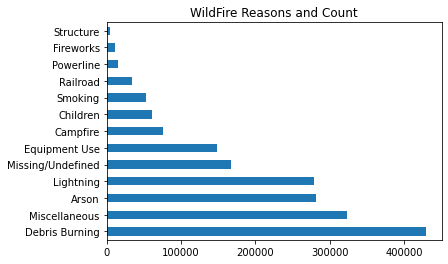

In [ ]:
# Number of Fires and different reasons
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh')
plt.title('WildFire Reasons and Count')
plt.show()


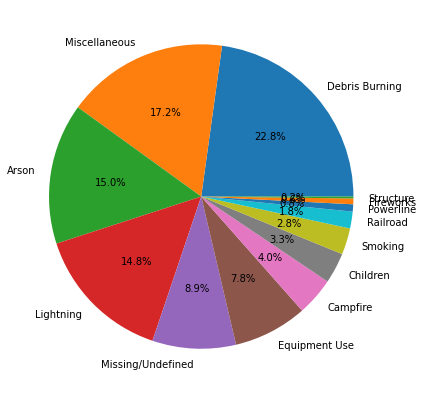

In [ ]:
causes = df['STAT_CAUSE_DESCR'].value_counts()
fig = plt.figure(figsize =(10, 7))
plt.pie(causes, autopct='%1.1f%%',labels=causes.index)
plt.show()

Debris burning , Arson, Lightning are the major causes of wildfire accounting for more than 50% of total wildfires

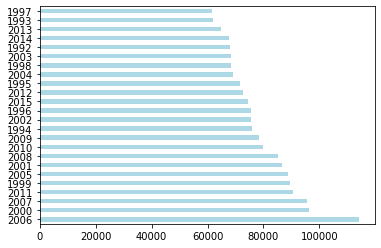

In [ ]:
df['FIRE_YEAR'].value_counts().plot(kind='barh',color='lightblue')
plt.show()

There is no significant difference in year on year wildfire count

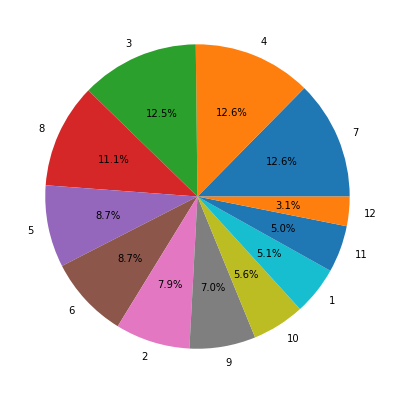

In [ ]:
months = df['MONTH'].value_counts()
fig = plt.figure(figsize =(10, 7))
plt.pie(months, autopct='%1.1f%%',labels=months.index)
plt.show()

There is significant difference between wildfire count from October-January and February-September. It might be because of weather, since weather is cold from October-January which is not conducive for wildfire. 

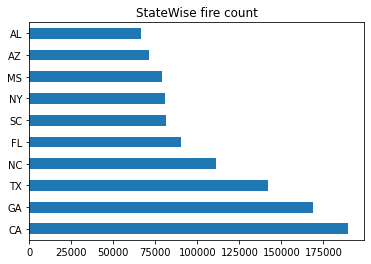

In [ ]:
# Plotting statewise firecount
df['STATE'].value_counts().head(n=10).plot(kind='barh')
plt.title('StateWise fire count')
plt.show()

In [ ]:
df_CA = df[df['STATE']=='CA']
df_GA = df[df['STATE']=='GA']
df_TX = df[df['STATE']=='TX']

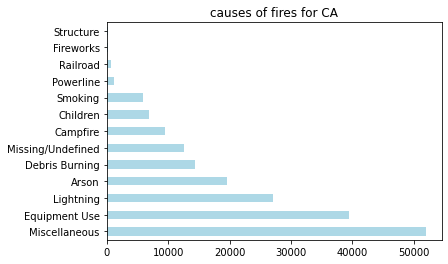

In [ ]:
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for CA')
plt.show()

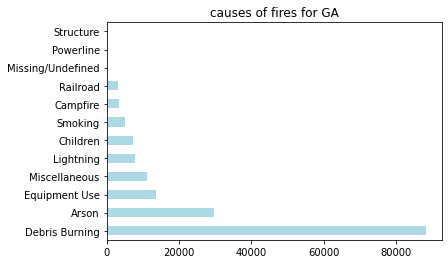

In [ ]:
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for GA')
plt.show()

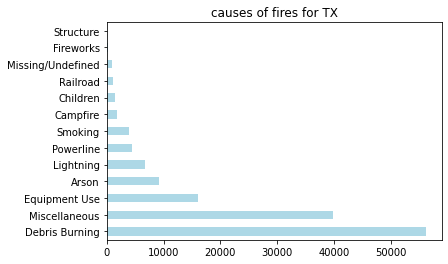

In [ ]:
df_TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for TX')
plt.show()

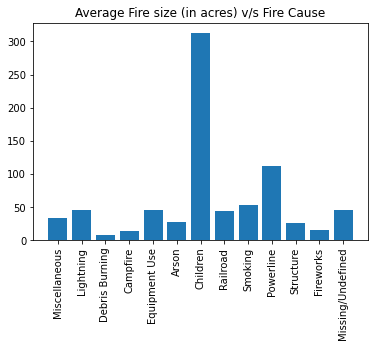

In [ ]:
# plotting firesize vs firecause
df1 = df.groupby('STAT_CAUSE_DESCR').mean()
plt.bar(df['STAT_CAUSE_DESCR'].unique(),df1['FIRE_SIZE'])
plt.xticks(rotation=90)
plt.title('Average Fire size (in acres) v/s Fire Cause')
plt.show()


Causes of fire vary state by state, so location will be critical attribute in prediction.

# Visualising the Dataset:


In [ ]:
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df.rename(columns = {"STAT_CAUSE_DESCR":"CAUSE"}, inplace="True")

In [ ]:
df.head()

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,CAUSE
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,4,63,7
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,4,61,6
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,4,17,3
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,4,3,6
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,4,3,6


In [ ]:
df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['START_DATE']).weekday

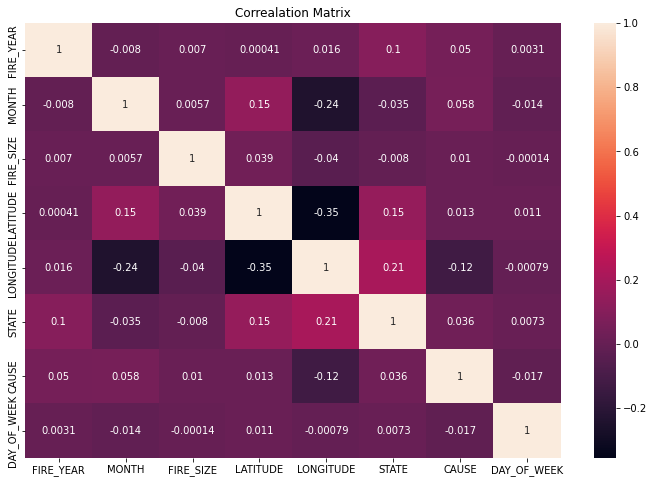

In [ ]:
#Corralation
plt.figure(figsize=(12, 8))
df_copy = df.drop('FOD_ID', axis=1)
corr = df_copy.corr()
sb.heatmap(corr, annot=True)
plt.title('Correalation Matrix')
plt.show()


In [ ]:
df.head()

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,CAUSE,DAY_OF_WEEK
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,4,63,7,2
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,4,61,6,2
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,4,17,3,0
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,4,3,6,0
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,4,3,6,0


In [ ]:
xdf = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','CAUSE'], axis=1)
ydf = df['CAUSE']

X = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','CAUSE'], axis=1).values
y = df['CAUSE'].values

In [ ]:
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) 

In [ ]:
#model1 = ske.RandomForestClassifier(n_estimators=50)
#model1 = model1.fit(X_train, y_train)
#print(model1.score(X_test,y_test))

In [ ]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

df['LABEL'] = df_original['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df = df.drop('CAUSE',axis=1)
print(df.head())

   FOD_ID  FIRE_YEAR  MONTH START_DATE  ... STATE COUNTY DAY_OF_WEEK  LABEL
0       1       2005      2 2005-02-02  ...     4     63           2      4
1       2       2004      5 2004-05-12  ...     4     61           2      1
2       3       2004      5 2004-05-31  ...     4     17           0      2
3       4       2004      6 2004-06-28  ...     4      3           0      1
4       5       2004      6 2004-06-28  ...     4      3           0      1

[5 rows x 15 columns]


In [ ]:
df['LABEL'].value_counts()

2    830014
4    490528
3    281455
1    278468
Name: LABEL, dtype: int64

In [ ]:
X = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','LABEL'], axis=1).values
y = df['LABEL'].values
print(set(y))
#print(df.columns)

{1, 2, 3, 4}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [ ]:
import torch
# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')



Using CPU


# General Methods

## Random Forest Classifier

In [ ]:
model2 = ske.RandomForestClassifier(n_estimators=50)
model2 = model2.fit(X_train, y_train)
print(model2.score(X_test,y_test))

0.6959105895699649


In [ ]:
y_pred = model2.fit(X_train, y_train).predict(X_test)
#y_pred = model2.predict(X_test)
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[ 65901  11512   1033   4870]
 [ 11146 196655  18223  23304]
 [  1611  34437  40494   7628]
 [  6812  44943   5900  89671]]


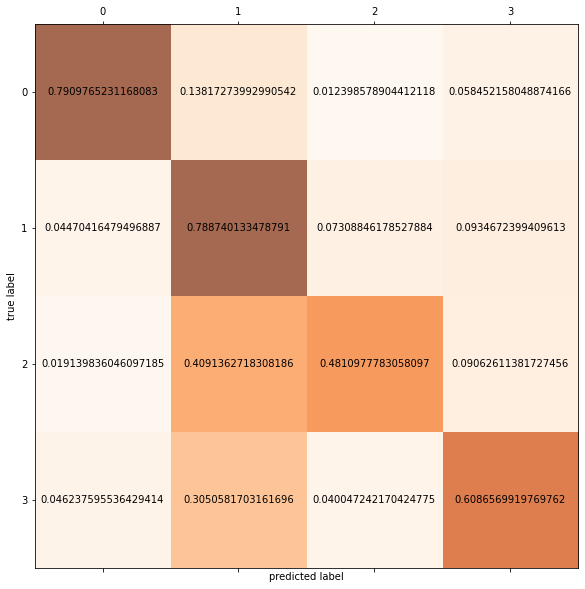

In [ ]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

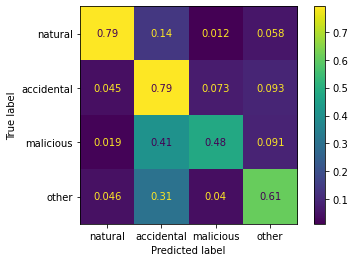

In [ ]:
cm_rfc = confusion_matrix(y_test,y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,display_labels=['natural','accidental','malicious','other'])
disp.plot()


## SVM

In [ ]:

svm.fit(X_train, y_train)
# predicting the test dataset values 
y_pred = svm.predict(X_test)
# printing classification report which has precision,recall,accuraccy...etc
print(classification_report(y_test, y_pred))

NameError: ignored

In [ ]:

svm = SVC(kernel='rbf', C = 10)
svm.fit(X_train, y_train)
# predicting the test dataset values 
y_pred = svm.predict(X_test)
# printing classification report which has precision,recall,accuraccy...etc
print(classification_report(y_test, y_pred))

## K Nearest Neighbor Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
#knn.score(X_test, y_test)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.67      0.77      0.72     83316
           2       0.64      0.74      0.69    249328
           3       0.49      0.37      0.42     84170
           4       0.68      0.54      0.60    147326

    accuracy                           0.64    564140
   macro avg       0.62      0.61      0.61    564140
weighted avg       0.63      0.64      0.63    564140



## Multi - Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train,y_train)
#mlp.score(X_test, y_test)
y_pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, y_pred_mlp))

## ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
ann=Sequential()
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.2))                
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.2))
ann.add(Dense(64, activation='relu')) 
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy']) 

ann.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1) 


Epoch 1/10
13164/13164 [==============================] - 35s 3ms/step - loss: -40267461689344.0000 - accuracy: 0.1483
Epoch 2/10
13164/13164 [==============================] - 35s 3ms/step - loss: -726570624876544.0000 - accuracy: 0.1483
Epoch 3/10
13164/13164 [==============================] - 37s 3ms/step - loss: -3755046151913472.0000 - accuracy: 0.1483
Epoch 4/10
13164/13164 [==============================] - 37s 3ms/step - loss: -11830888996274176.0000 - accuracy: 0.1483
Epoch 5/10
13164/13164 [==============================] - 36s 3ms/step - loss: -28603769226788864.0000 - accuracy: 0.1483
Epoch 6/10
13164/13164 [==============================] - 35s 3ms/step - loss: -58655934569775104.0000 - accuracy: 0.1483
Epoch 7/10
13164/13164 [==============================] - 36s 3ms/step - loss: -107523071736283136.0000 - accuracy: 0.1483
Epoch 8/10
13164/13164 [==============================] - 36s 3ms/step - loss: -181579277265797120.0000 - accuracy: 0.1483
Epoch 9/10
13164/13164 [====

In [ ]:
ann.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                

In [ ]:
y_pred_ann = ann.predict(X_test)
print(classification_report(y_test,y_pred_ann))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.15      1.00      0.26     83316
           2       0.00      0.00      0.00    249328
           3       0.00      0.00      0.00     84170
           4       0.00      0.00      0.00    147326

    accuracy                           0.15    564140
   macro avg       0.04      0.25      0.06    564140
weighted avg       0.02      0.15      0.04    564140



## CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout,Conv1D, Conv2D, MaxPooling1D, Flatten, LSTM
from keras.layers import LeakyReLU, PReLU, ELU, Activation, GRU, SimpleRNN

In [ ]:
model = Sequential()
#input_shape=(train_X.shape[0],train_X.shape[1])
model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(GRU(256, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(256,activation='relu'))
model.add(Dense(1025,activation='relu'))
model.compile(loss='mse', optimizer='adam',metrics=['mse'])

In [ ]:
print(X_train.shape)
print(y_train.shape)  

(1316325, 7)
(1316325,)


In [ ]:
train_X = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
train_Y = [y_train]#.reshape((y_train.shape[0], 1))
#train_Y = y_train.reshape((train_Y.shape[0],1, train_Y.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape)
print(train_Y.shape)


AttributeError: ignored

In [ ]:
hist = model.fit(train_X, train_Y, batch_size=100, epochs=3)

Epoch 1/3


TypeError: ignored

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           multiple                  2816      
_________________________________________________________________
max_pooling1d_44 (MaxPooling multiple                  0 (unused)
_________________________________________________________________
conv1d_46 (Conv1D)           multiple                  0 (unused)
_________________________________________________________________
max_pooling1d_45 (MaxPooling multiple                  0 (unused)
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0 (unused)
_________________________________________________________________
conv1d_47 (Conv1D)           multiple                  0 (unused)
_________________________________________________________________
max_pooling1d_46 (MaxPooling multiple                

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred_lrcv = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred_lrcv))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.29      0.01      0.03     84170
           1       0.00      0.00      0.00     22818
           2       0.00      0.00      0.00     18240
           3       0.31      0.80      0.44    129099
           4       0.00      0.00      0.00     44329
           5       0.00      0.00      0.00      3415
           6       0.37      0.74      0.50     83316
           7       0.18      0.07      0.10     97026
           8       0.39      0.17      0.24     50300
           9       0.00      0.00      0.00      4289
          10       0.00      0.00      0.00     10053
          11       0.00      0.00      0.00     15925
          12       0.00      0.00      0.00      1160

    accuracy                           0.32    564140
   macro avg       0.12      0.14      0.10    564140
weighted avg       0.23      0.32      0.22    564140



# LSTM

In [ ]:
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout, Conv1D, MaxPooling1D
import keras.utils
from keras.utils.np_utils import to_categorical
from keras.layers import LSTM



In [ ]:
xdf = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','LABEL'], axis=1)
ydf = df['LABEL']

print(xdf.shape)
print(ydf.shape)

(1880465, 7)
(1880465,)
(1880465, 7)
(1880465,)


In [ ]:
x, x_test, y, y_test = train_test_split(xdf,ydf,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

print("X_train, Y_train shape",x_train.shape, y_train.shape)
print("\nX_val, Y_val shape",x_val.shape, y_val.shape)
print("\nX_test, Y_test shape",x_test.shape, y_test.shape)

X_train, Y_train shape (1128279, 7) (1128279,)

X_val, Y_val shape (376093, 7) (376093,)

X_test, Y_test shape (376093, 7) (376093,)


In [ ]:
scaler = RobustScaler()

scaler_train = scaler.fit(x_train)
scaler_val = scaler.fit(x_val)

x_train.loc[:] = scaler_train.transform(x_train.to_numpy())
x_val.loc[:] = scaler_train.transform(x_val.to_numpy())

In [ ]:
from scipy.stats import mode

def create_dataset(x, y, timesteps, step):
  x_set = []
  y_set = []
  for i in range(0,len(x)-timesteps, step):
    data = x.iloc[i: (i + timesteps)].values
    labels = y.iloc[i: i + timesteps]
    x_set.append(data)
    y_set.append(mode(labels)[0][0])
  
  return np.array(x_set), np.array(y_set).reshape(-1,1)

timesteps = 1
steps = 1

X_train, Y_train = create_dataset( x_train, y_train, timesteps, steps)
X_val , Y_val = create_dataset( x_val, y_val, timesteps, steps)

In [ ]:
from tensorflow.keras.utils import to_categorical

print(X_train.shape) #(1116238-timesteps, timesteps, 6)
print(Y_train.shape) #(1116238-timesteps, 1)

print(X_val.shape) #(177270-timesteps, timesteps, 6)
print(Y_val.shape) #(177270-timesteps, timesteps, 1)
print()

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
print(Y_train.shape) #(1116238-timesteps, 4)
print(Y_val.shape) #(177270-timesteps, 4)


(1128278, 1, 7)
(1128278, 1)
(376092, 1, 7)
(376092, 1)

(1128278, 5)
(376092, 5)


In [ ]:
num = 4
batch_size = 128
epochs = 10

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(LSTM( units = 128, input_shape = [X_train.shape[1],X_train.shape[2]])))
model.add(Dropout(rate = 0.6))
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units = 64,activation='relu'))
model.add(Dense(units=5,activation='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['Accuracy'])


In [ ]:
history = model.fit(X_train,Y_train, epochs = 3, batch_size = batch_size, validation_data= (X_val,Y_val))

Epoch 1/3
8815/8815 [==============================] - 88s 10ms/step - loss: 1.0110 - Accuracy: 0.5625 - val_loss: 0.9487 - val_Accuracy: 0.5948
Epoch 2/3
8815/8815 [==============================] - 87s 10ms/step - loss: 0.9642 - Accuracy: 0.5881 - val_loss: 0.9265 - val_Accuracy: 0.6019
Epoch 3/3
8815/8815 [==============================] - 87s 10ms/step - loss: 0.9498 - Accuracy: 0.5955 - val_loss: 0.9159 - val_Accuracy: 0.6108


In [ ]:
model.summary()
y_val_pred = model.predict(X_val)
print(y_val_pred.shape)
p = np.argmax(y_val_pred,axis=1)
q = np.argmax(Y_val,axis=1)
print(p.shape)
print(q.shape)
print(classification_report(q,p))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 256)              139264    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 180,741
Trainable params: 180,741
Non-trainable params: 0
________________________________________________

# CNN

In [ ]:
timesteps = 40
X_train, Y_train = create_dataset( x_train, y_train, timesteps, steps)
X_val , Y_val = create_dataset( x_val, y_val, timesteps, steps)

print(X_train.shape) #(1116238-timesteps, timesteps, 6)
print(Y_train.shape) #(1116238-timesteps, 1)

print(X_val.shape) #(177270-timesteps, timesteps, 6)
print(Y_val.shape) #(177270-timesteps, timesteps, 1)
print()

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
print(Y_train.shape) #(1116238-timesteps, 4)
print(Y_val.shape) #(177270-timesteps, 4)


(1128239, 40, 7)
(1128239, 1)
(376053, 40, 7)
(376053, 1)

(1128239, 5)
(376053, 5)


In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 38, 128)           2816      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 64)            24640     
                                                                 
 dropout_3 (Dropout)         (None, 17, 64)            0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [ ]:
# fit network
model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=2, batch_size=batch_size, verbose=1)
  

Epoch 1/2
8815/8815 [==============================] - 226s 26ms/step - loss: 0.2865 - accuracy: 0.9261 - val_loss: 0.2870 - val_accuracy: 0.9249
Epoch 2/2
8815/8815 [==============================] - 228s 26ms/step - loss: 0.2821 - accuracy: 0.9261 - val_loss: 0.2858 - val_accuracy: 0.9249


In [ ]:
model.summary()
y_val_pred = model.predict(X_val)
print(y_val_pred.shape)
p = np.argmax(y_val_pred,axis=1)
q = np.argmax(Y_val,axis=1)
print(p.shape)
print(classification_report(q,p))


NameError: ignored